# Notebook for generating all an only the figures related to the paper!

## General setup

### Figure path

In [1]:
PATH="../PAPER_DIFFUSION/figs/"
DPI=600

### Libraries

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
# For parallelization
from joblib import Parallel, delayed

import nekhoroshev_tools as nt

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
def afpt(I_min, I_max, I_star, exponent, c=None):
    if c is None:
        c = nt.standard_c(0.0, I_max, I_star, exponent)
    return scipy.integrate.quad(
        lambda x: 2*x/nt.D(x, I_star, exponent, c=c),
        I_min,
        I_max
    )[0]

### Test for the path

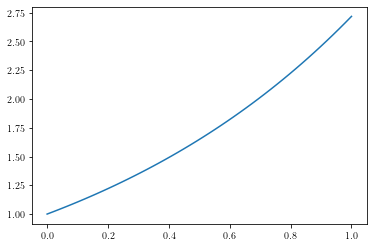

In [6]:
plt.figure()
plt.plot(np.linspace(0, 1), np.exp(np.linspace(0, 1)))

plt.savefig(os.path.join(PATH+"test.pdf"), dpi=DPI)

## 1 - Model presentation

### Just the diffusion coefficient

In [72]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)
k_low = 0.10
exponent_low = 1/(k_low*2)
k_high = 0.50
exponent_high = 1/(k_high*2)

In [83]:
I = np.linspace(0.01, 2.0, 1000)

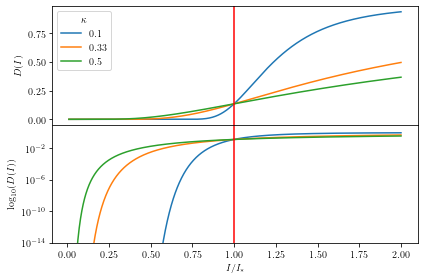

In [84]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(I, nt.D(I, I_star, exponent_low), label=str(k_low))
ax1.plot(I, nt.D(I, I_star, exponent_low))
ax0.plot(I, nt.D(I, I_star, exponent), label=str(k))
ax1.plot(I, nt.D(I, I_star, exponent))
ax0.plot(I, nt.D(I, I_star, exponent_high), label=str(k_high))
ax1.plot(I, nt.D(I, I_star, exponent_high))

ax0.legend(title="$\\kappa$")

ax0.axvline(I_star, c="red")
ax1.axvline(I_star, c="red")

ax1.set_yscale("log")
ax1.set_ylim(bottom=1e-14, top=10)

plt.setp(ax0.get_xticklabels(), visible=False)

ax1.set_xlabel("$I/I_*$")
ax0.set_ylabel("$D(I)$")
ax1.set_ylabel("$\\log_{10}(D(I))$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)

plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-3].label1.set_visible(False)

plt.savefig(os.path.join(PATH+"diffusion_coefficient.pdf"), dpi=DPI)

### Average First Passage Time

In [39]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

I_min = 0.1
I_max_low = 0.2
I_max_mid = 0.8
I_max_high = 2.0

In [52]:
I_low = np.linspace(I_min, I_max_low, 10000, endpoint=False)
I_mid = np.linspace(I_min, I_max_mid, 10000, endpoint=False)
I_high = np.linspace(I_min, I_max_high, 10000, endpoint=False)

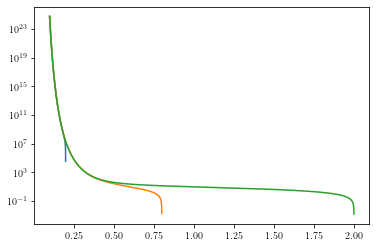

In [53]:
plt.figure()

plt.plot(I_low, [afpt(I, I_max_low, I_star, exponent, c=1.0) for I in I_low])
plt.plot(I_mid, [afpt(I, I_max_mid, I_star, exponent, c=1.0) for I in I_mid])
plt.plot(I_high, [afpt(I, I_max_high, I_star, exponent, c=1.0) for I in I_high])

plt.yscale("log")

## 2 - Ideal reconstruction 

## 3 - Semi-ideal reconstruction

This is the **core experiment** I will discuss most in the paper, so everything must be perfect!

### First, we need to define a realistic initial distribution

It's very simple and direct: if we decide to work in normalized emittance variables, and we work with a gaussian beam distribution with it's characteristic emittance, we have that
$$\rho_0(I) = e^{-I}$$
Where $I$, from now on, is expessed in sigma units.

In [5]:
def rho_0(I, damping_position=np.nan, l=np.nan):
    if np.isnan(damping_position) or np.isnan(l):
        return np.exp(-I)
    else:
        return np.exp(-I) / (1 + np.exp((I - damping_position)/l))

### Setting up the scenario

In [6]:
I_damping = 1.9
I_max = 2.0
I_star = 10.0
k = 0.33
exponent = 1/(2*k)

# As for the time scaling... we go with this one.
# REMEMBER TO SPECIFY IT PROPERLY IN THE PAPER!!!
c = nt.standard_c(0.0, I_max, I_star, exponent)

In [68]:
cn_sampling = 10000
I_list, dI = np.linspace(0.0, I_max, cn_sampling, retstep=True)

cn_time_steps = 100
dt = nt.current_peak_time(I_damping, I_max, I_star, exponent, c)/cn_time_steps

In [69]:
steps_per_sample = 5

steps_per_iteration = 10000
iterations = 10
macro_iterations = 5
long_track_steps = steps_per_iteration * iterations * (macro_iterations + 1)

In [70]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps, steps_per_sample, False)
data_long = engine.get_data_with_x()

100%|██████████| 600000/600000 [07:24<00:00, 1349.67it/s]


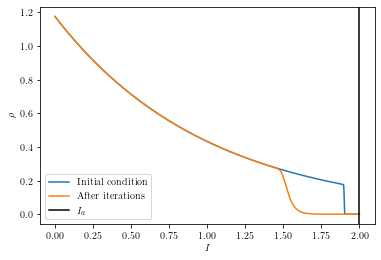

In [71]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

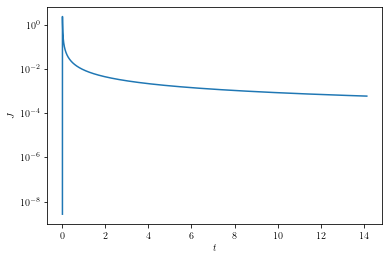

In [72]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [73]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        engine.move_barrier_forward(0.1)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Barrier position')

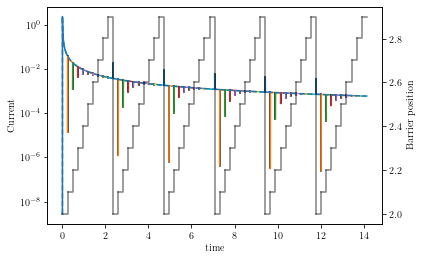

In [74]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

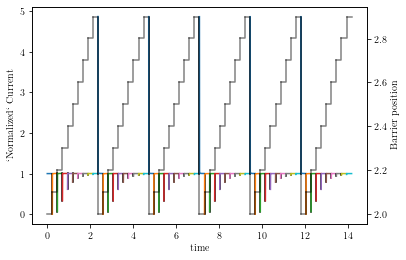

In [75]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

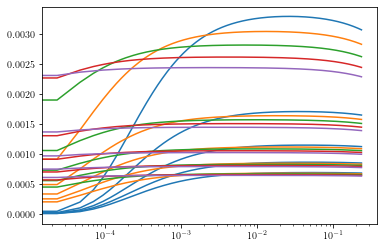

In [76]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.8, 1.0)

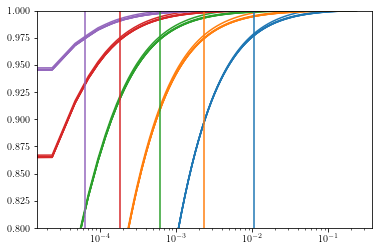

In [77]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[1], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[2], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[3], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[4], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

fit!

In [106]:
def the_func(x_list, I_star, exponent):
    print(I_star, exponent)
    I_start  = [x[0] for x in x_list]
    I_end = [x[1] for x in x_list]
    
    t_list = np.array([afpt(I_start[i], I_end[i], I_star, exponent, c) for i in range(len(I_start))])
    return t_list

In [123]:
selected_times = []
x_list = []

for i in range(len(c_normalized_out)):
    if i%iterations!=0:
        selected_times.append(
            t_absolute_out[0][
                np.argmin(np.absolute(c_normalized_out[i] - 0.96))
            ]
        )
        x_list.append(
            (I_max_list[i-1], I_max_list[i])
        )

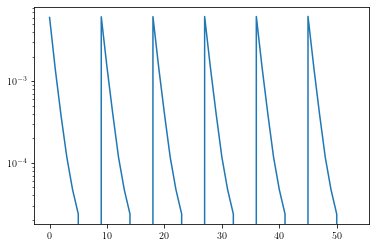

In [124]:
plt.plot(selected_times)
plt.yscale("log")

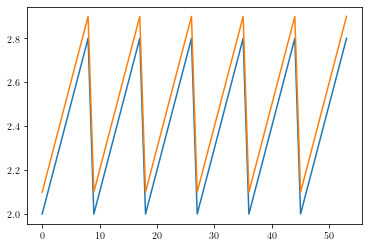

In [125]:
plt.plot(x_list)

In [126]:
popt, pcov = scipy.optimize.curve_fit(
    the_func,
    x_list,
    np.asarray(selected_times),
    p0=(I_star, exponent)
)

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.021892109707357 1.5012794933185931
10.021892259045186 1.5012794933185931
10.021892109707357 1.5012795156894008
10.170361389178803 1.483909473782405
10.170361540728997 1.483909473782405
10.170361389178803 1.4839094958943793
10.197209818286442 1.4815041890182439
10.19720997023671 1.4815041890182439
10.197209818286442 1.4815042110943766
10.197085396579315 1.4815225527889655
10.197085548527728 1.4815225527889655
10.197085396579315 1.481522574865372
10.197087579505201 1.4815223548203307


others...

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        print(engine.I_max)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
            print(engine.I_max)
            
        engine.move_barrier_forward(0.1 * (i+1))
        print(engine.I_max)
        

Text(0, 0.5, 'Barrier position')

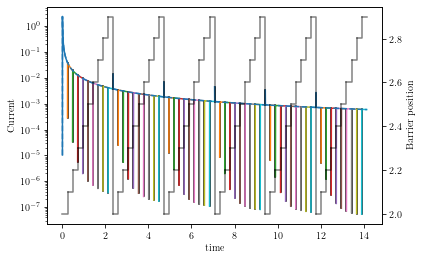

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

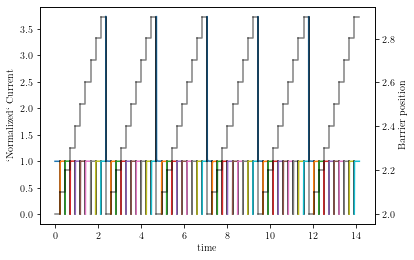

In [29]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

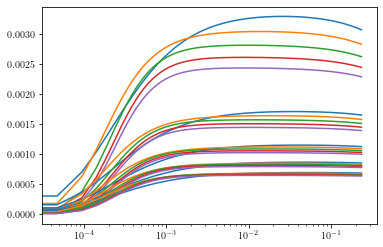

In [30]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.8, 1.0)

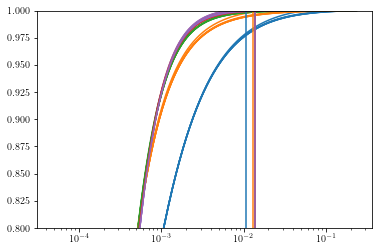

In [32]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

In [37]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps*2, steps_per_sample, False)
data_long = engine.get_data_with_x()

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 600000/600000 [07:26<00:00, 1343.31it/s]


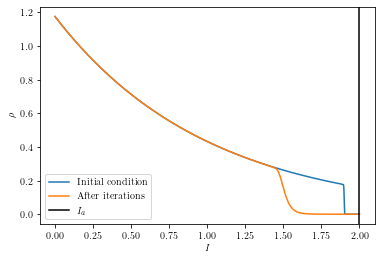

In [38]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

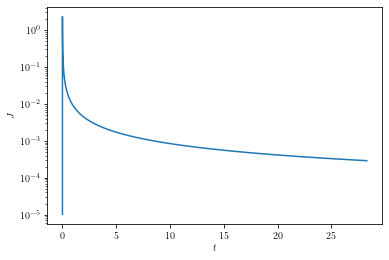

In [39]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [40]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        t_relative_out_partial.append(time)
        t_absolute_out_partial.append(absolute_time)
        c_out_partial.append(current)
        I_max_list_partial.append(engine.I_max)
        set_list_partial.append(i)

            
        engine.move_barrier_forward(0.1 * (i+1))
        

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Barrier position')

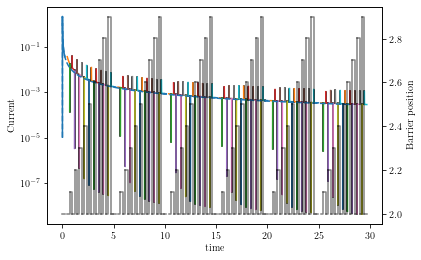

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

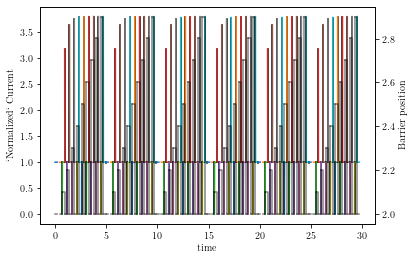

In [45]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

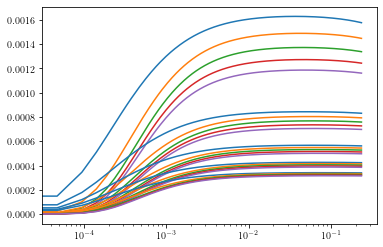

In [50]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%(iterations*2)==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%(iterations*2)==6 and i != 6:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%(iterations*2)==8 and i != 8:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%(iterations*2)==10 and i != 10:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.005, 0.02)

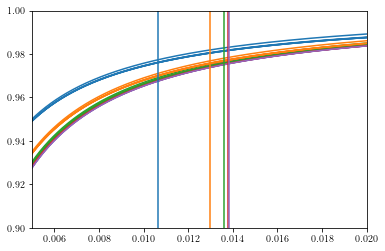

In [62]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%(iterations*2)==4:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%(iterations*2)==6:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%(iterations*2)==8:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%(iterations*2)==10:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[6], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[8], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[10], I_star, exponent, c), c="C4")

#plt.xscale("log")
plt.ylim(0.9,1.0)
plt.xlim(5e-3, 2e-2)

## 4 - Experimental data